# BERTweet-Large

## Imports

In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from captum.attr import *
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pydictobject import DictObject

from BERTweet.TweetNormalizer import *

# Ensure deterministic behavior
seed = 12345678
# seed = 87654321

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import wandb
wandb.login()

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/alexlu/miniconda3/envs/alzheimers/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda:0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexlu314. Use `wandb login --relogin` to force relogin


In [2]:
def log_memory():
    print(torch.cuda.memory_allocated() / 1e9)

## Data

In [3]:
class AlzheimersTweetsDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None, padding=True):
        self.tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)
        self.tokenizer.model_max_length = 512
        self.transform = transform
        self.target_transform = target_transform

        self.df = pd.read_csv(root)
        self.length = len(self.df)

        self.tweets = self.tokenizer(normalizeTweet(self.df["tweet"].values), padding=padding, max_length=512, truncation=True, return_tensors='pt')["input_ids"]
        self.labels = torch.LongTensor(self.df["label"].values)

        if self.transform is not None:
            self.tweets = self.transform(self.tweets)

        if self.target_transform is not None:
            self.labels = self.target_transform(self.labels)
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.tweets[idx], self.labels[idx]

In [4]:
def get_data(path=None, augment=None, **kwargs):
    if path:
        if path == "test":
            return AlzheimersTweetsDataset("data/test.csv", **kwargs)
        
        return AlzheimersTweetsDataset(path, **kwargs)
    
    if augment == 50/50:
        trainset = AlzheimersTweetsDataset("data/train_augment_5050.csv", **kwargs)
    elif augment == 75/25:
        trainset = AlzheimersTweetsDataset("data/train_augment_7525.csv", **kwargs)
    else:
        trainset = AlzheimersTweetsDataset("data/train.csv", **kwargs)
        
    valset = AlzheimersTweetsDataset("data/val.csv", **kwargs)
    return trainset, valset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        pin_memory=True, num_workers=2)
    return loader

## Model

In [5]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large")

# Training

In [6]:
def train(model, train_loader, val_loader, optimizer, config):    
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    # wandb.watch(model, log="all", log_freq=10)

    best_epoch = None
    best_val_accuracy = -1

    # Run training and track with wandb
    example_ct = 0  # number of examples seen
    batch_ct = 0

    for epoch in tqdm(range(config.epochs)):
        model.train()
        train_correct, val_correct = 0, 0
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)

            output = model(batch, labels=labels)
            loss = output.loss

            partial_loss = loss / config.accum
            partial_loss.backward()
            
            predicted = output.logits.argmax(dim=-1)
            train_correct += (predicted == labels).sum().item()

            example_ct += len(batch)
            batch_ct += 1

            if (batch_ct % config.accum == 0) or (batch_ct == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

            if (batch_ct % (config.log_interval * config.accum)) == 0:
                wandb.log({"epoch": epoch, "loss": loss.item()}, step=example_ct)
                print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

        with torch.no_grad():
            model.eval()
            for batch, labels in val_loader:
                batch, labels = batch.to(device), labels.to(device)
                output = model(batch, labels=labels)

                predicted = output.logits.argmax(dim=-1)
                val_correct += (predicted == labels).sum().item()
        
        train_accuracy = train_correct / len(train_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        if val_accuracy > best_val_accuracy:
            best_epoch = epoch
            best_val_accuracy = val_accuracy

        wandb.log({"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}, step=example_ct)
        print(f"Epoch {str(epoch).zfill(2)} Summary: (Train %: {train_accuracy:%}, Val%: {val_accuracy:%})")

        # model.save_pretrained(os.path.join(wandb.run.dir, f"model_{epoch}"))
        model.save_pretrained(os.path.join("results", f"model_{epoch}"))

    return best_epoch

# Final Test

In [23]:
def test(config, model, data_dir="test", use_wandb=True):
    if not use_wandb:
        config = DictObject(config)

    model.eval()

    test = get_data(data_dir)
    test_loader = make_loader(test, batch_size=config.batch_size//config.accum)

    correct = 0
    predicted_true = 0
    target_true = 0
    correct_true = 0
    with torch.no_grad():
        for batch, labels in test_loader:
            batch, labels = batch.to(device), labels.to(device)
            output = model(batch, labels=labels)

            predicted = output.logits.argmax(dim=-1)
            correct += (predicted == labels).sum().item()

            predicted_true += (predicted == 1).sum().item()
            target_true += (labels == 1).sum().item()
            correct_true += ((predicted == 1) * (labels == 1)).sum().item()
    
    accuracy = correct / len(test_loader.dataset)
    precision = correct_true / predicted_true
    recall = correct_true / target_true
    f1_score = 2 * precision * recall / (precision + recall)

    if use_wandb:
        wandb.log({"test_accuracy": accuracy})
    print(f"Final Test Accuracy: {accuracy}")

    return accuracy, precision, recall, f1_score


## Pipeline

In [8]:
def make(config):
    # Make the data
    train, val = get_data(augment=config.augment)
    train_loader = make_loader(train, batch_size=config.batch_size//config.accum)
    val_loader = make_loader(val, batch_size=config.batch_size//config.accum)

    # Make the model
    model = get_model().to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, val_loader, optimizer


In [9]:
def model_pipeline(hyperparameters):
    assert hyperparameters["batch_size"] % hyperparameters["accum"] == 0

    # tell wandb to get started
    with wandb.init(project="Alzheimers", config=hyperparameters):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, val_loader, optimizer = make(config)
        print(model)

        # and use them to train the model
        best_epoch = train(model, train_loader, val_loader, optimizer, config)
        print("Best Epoch:", best_epoch)

        # and run test its final performance
        # model.from_pretrained(os.path.join(wandb.run.dir, f"model_{best_epoch}"))
        model = model.from_pretrained(os.path.join("results", f"model_{best_epoch}")).to(device)
        test(config, model)
      
    return model

# Run

In [10]:
config = {
    "epochs": 40,
    "batch_size": 32,
    "accum": 1,
    "learning_rate": 1e-5,
    "log_interval": 4,
    "augment": None,
}

In [11]:
stop

NameError: name 'stop' is not defined

In [ ]:
model = model_pipeline(config)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'c

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

  0%|          | 0/40 [00:00<?, ?it/s]

Loss after 00128 examples: 0.558
Loss after 00256 examples: 0.567
Loss after 00384 examples: 0.610
Loss after 00512 examples: 0.638
Loss after 00640 examples: 0.601
Loss after 00768 examples: 0.621
Loss after 00896 examples: 0.603
Loss after 01024 examples: 0.647
Loss after 01152 examples: 0.694
Loss after 01280 examples: 0.669
Loss after 01408 examples: 0.572
Loss after 01536 examples: 0.581
Loss after 01664 examples: 0.576
Loss after 01792 examples: 0.548
Loss after 01920 examples: 0.679
Loss after 02048 examples: 0.674
Loss after 02176 examples: 0.516
Loss after 02304 examples: 0.711
Loss after 02432 examples: 0.662
Loss after 02560 examples: 0.558
Loss after 02688 examples: 0.682
Loss after 02816 examples: 0.705
Loss after 02944 examples: 0.622
Loss after 03072 examples: 0.607
Loss after 03200 examples: 0.578
Loss after 03328 examples: 0.599
Loss after 03456 examples: 0.574
Loss after 03584 examples: 0.462
Loss after 03712 examples: 0.624
Loss after 03840 examples: 0.512
Loss after

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▃▂▂▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁
train_accuracy,▁▄▆▇▇███████████████████████████████████
val_accuracy,▁▇▇██████▇█▇▇██████████▇████████████████
epoch,39
loss,5e-05
train_accuracy,0.99977
val_accuracy,0.95749


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
print(torch.cuda.memory_allocated(0))

0


In [ ]:
stop

NameError: name 'stop' is not defined

## Test Generalization

In [17]:
model = get_model().from_pretrained("results/model_39/").to(device)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

In [18]:
test(config, model, use_wandb=False)

Final Test Accuracy: 0.9482439926062847


(0.9482439926062847,
 0.9596774193548387,
 0.9648648648648649,
 0.9622641509433963)

In [19]:
test(config, model, data_dir="test_generalization.csv", use_wandb=False)

Final Test Accuracy: 0.44


(0.44, 0.3170731707317073, 1.0, 0.48148148148148145)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.7467652495378928
Final Test Accuracy: 0.255


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9297597042513863
Final Test Accuracy: 0.285


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9463955637707948
Final Test Accuracy: 0.295


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9390018484288355
Final Test Accuracy: 0.365


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9316081330868762
Final Test Accuracy: 0.5


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9482439926062847
Final Test Accuracy: 0.42


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9463955637707948
Final Test Accuracy: 0.42


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9463955637707948
Final Test Accuracy: 0.395


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9593345656192237
Final Test Accuracy: 0.385


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.325


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.933456561922366
Final Test Accuracy: 0.495


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9260628465804066
Final Test Accuracy: 0.46


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.955637707948244
Final Test Accuracy: 0.5


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.37


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9500924214417745
Final Test Accuracy: 0.41


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9630314232902033
Final Test Accuracy: 0.355


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.41


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9574861367837338
Final Test Accuracy: 0.38


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9500924214417745
Final Test Accuracy: 0.445


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9593345656192237
Final Test Accuracy: 0.49


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9593345656192237
Final Test Accuracy: 0.44


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9500924214417745
Final Test Accuracy: 0.385


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.944547134935305
Final Test Accuracy: 0.375


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9500924214417745
Final Test Accuracy: 0.3


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9519408502772643
Final Test Accuracy: 0.45


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9482439926062847
Final Test Accuracy: 0.37


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.4


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9426987060998152
Final Test Accuracy: 0.525


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.43


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.955637707948244
Final Test Accuracy: 0.385


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.955637707948244
Final Test Accuracy: 0.445


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.405


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.955637707948244
Final Test Accuracy: 0.415


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9537892791127541
Final Test Accuracy: 0.395


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9519408502772643
Final Test Accuracy: 0.42


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9500924214417745
Final Test Accuracy: 0.325


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.944547134935305
Final Test Accuracy: 0.395


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9519408502772643
Final Test Accuracy: 0.455


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9500924214417745
Final Test Accuracy: 0.435


Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'c

Final Test Accuracy: 0.9482439926062847
Final Test Accuracy: 0.44


array([<Axes: >, <Axes: >], dtype=object)

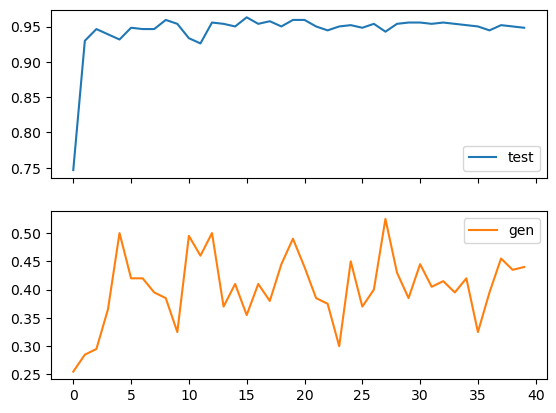

In [24]:
# tes = []
# gen = []

# for i in range(40):
#     model = get_model().from_pretrained(f"results/model_{i}/").to(device)
#     tes.append(test(config, model, use_wandb=False)[0])
#     gen.append(test(config, model, data_dir="test_generalization.csv", use_wandb=False)[0])

# df = pd.DataFrame({"test": tes, "gen": gen})
# df.plot.line(subplots=True)


## Captum

In [25]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)
tokenizer.model_max_length = 512

PAD_IND = tokenizer.encode("<pad>")[1]
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [26]:
lig = LayerIntegratedGradients(lambda x: model(x).logits, model.roberta.embeddings)

In [27]:
# accumalate couple samples in this array for visualization purposes

def interpret_sentences(model, sentences, labels, tokenize=[]):
    log_memory()
    classes = ["negative", "positive"]

    for i in tokenize:
        sentences[i] = tokenizer(normalizeTweet(sentences[i]), padding="max_length", truncation=True, return_tensors='pt')["input_ids"]
        
    if isinstance(sentences, list):
        sentences = torch.stack(sentences)
    sentences = sentences.to(device)

    text = [[tokenizer.decode(word) for word in sentence if tokenizer.decode(word) != "<pad>"] for sentence in sentences.cpu()]

    model.zero_grad()
    pred = model(sentences).logits.detach().cpu()
    pred_ind = pred.argmax(dim=-1)

    reference_indices = token_reference.generate_reference(tokenizer.model_max_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions, delta = lig.attribute(sentences, reference_indices, target=1, \
                                           n_steps=500, return_convergence_delta=True, internal_batch_size=24)

    vis_data_records = []
    for i in range(len(sentences)):
        print(f"pred: {classes[pred_ind[i]]} ({pred[i][1]:.2f}), delta: {abs(delta[i])}")

        attr = attributions[i]
        attr = attr.sum(dim=-1)
        attr = attr / torch.norm(attr)
        attr = attr.cpu().detach().numpy()

        # storing couple samples in an array for visualization purposes
        vis_data_records.append(visualization.VisualizationDataRecord(
                                attr,
                                pred[i][1],
                                classes[pred_ind[i]],
                                classes[labels[i]],
                                classes[1],
                                attr.sum(),
                                text[i],
                                delta[i]))

    return vis_data_records

In [28]:
test = get_data("test_generalization.csv", padding="max_length")

neg_indices = test.labels == 0
pos_indices = test.labels == 1

neg_tweets = test.tweets[neg_indices]
neg_labels = test.labels[neg_indices]

pos_tweets = test.tweets[pos_indices]
pos_labels = test.labels[pos_indices]

In [29]:
i = 0

sentences = pos_tweets[i*16:min((i+1)*16, len(pos_tweets))]
labels = pos_labels[i*16:min((i+1)*16, len(pos_tweets))]

pos_data_records = interpret_sentences(model, sentences, labels)
_ = visualization.visualize_text(pos_data_records)

1.429976576
pred: positive (5.38), delta: 5.4079816277651265
pred: positive (5.05), delta: 31.435998868165655
pred: positive (5.31), delta: 3.6806967647606417
pred: positive (5.29), delta: 13.067845409141459
pred: positive (5.03), delta: 0.5341949142575189
pred: positive (5.38), delta: 15.031716551934334
pred: positive (5.33), delta: 5.715209824196381
pred: positive (5.34), delta: 2.712522786154942
pred: positive (5.37), delta: 3.992983689297822
pred: positive (5.36), delta: 0.69594733820378
pred: positive (5.23), delta: 4.701888880197945
pred: positive (5.29), delta: 5.234277611258399
pred: positive (5.35), delta: 7.032971123090036
pred: positive (5.33), delta: 5.234080673689358
pred: positive (5.21), delta: 1.1661978638670654
pred: positive (5.35), delta: 5.074333112365181


In [30]:
i = 0

sentences = neg_tweets[i*16:min((i+1)*16, len(neg_tweets))]
labels = neg_labels[i*16:min((i+1)*16, len(neg_tweets))]

neg_data_records = interpret_sentences(model, sentences, labels)
visualization.visualize_text(neg_data_records)

1.438496768
pred: negative (-2.90), delta: 1.6966566834103611
pred: positive (0.29), delta: 2.428352350973384
pred: positive (5.30), delta: 2.5327669417787266
pred: positive (5.31), delta: 8.665402530769102
pred: negative (-2.11), delta: 3.5383431497339393
pred: negative (-2.48), delta: 3.806257995185155
pred: positive (0.31), delta: 3.920231857790694
pred: positive (4.87), delta: 6.336274907119614
pred: positive (5.27), delta: 3.6045166613923643
pred: positive (0.13), delta: 1.3644054986736887
pred: negative (-3.95), delta: 3.785751039831756
pred: positive (4.02), delta: 1.8454249043738251
pred: positive (5.13), delta: 0.23693834023912164
pred: positive (2.82), delta: 0.6402683673499414
pred: positive (3.56), delta: 0.7966530223034205
pred: positive (4.23), delta: 10.4886888646407


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

# interpretable_embedding = configure_interpretable_embedding_layer(model, "roberta.embeddings")

# PAD_IND = tokenizer.encode("<pad>")[1]
# token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

# def baseline_text(x):
#     seq_len = x.size(0)
#     ref_indices = token_reference.generate_reference(seq_len, device=device).unsqueeze(0)
#     return interpretable_embedding.indices_to_embeddings(ref_indices).squeeze(0)

# def input_text_transform(x):
#     return interpretable_embedding.indices_to_embeddings(x)


In [ ]:
# visualizer = AttributionVisualizer(
#     models=[model],
#     score_func=lambda x: nn.functional.softmax(x.logits, -1),
#     classes=["negative", "positive"],
#     features=[
#         TextFeature(
#             "Tweet",
#             input_transforms=[input_text_transform],
#             baseline_transforms=[baseline_text],
#             visualization_transform=tokenizer.decode,
#         ),
#     ],
#     dataset=formatted_dataset(dataset)
# )

In [ ]:
# visualizer.render(debug=True)

In [ ]:
# remove_interpretable_embedding_layer(model, "roberta.embeddings")